# Installation

In [2]:
!pip install transformers datasets evaluate


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [235]:
import matplotlib.pyplot as plt
import numpy as np

# Training Data Set

In [5]:
from datasets import load_dataset
load_dataset?

Signature:
load_dataset(
    path: str,
    name: Optional[str] = None,
    data_dir: Optional[str] = None,
    data_files: Union[str, Sequence[str], Mapping[str, Union[str, Sequence[str]]], NoneType] = None,
    split: Union[str, datasets.splits.Split, NoneType] = None,
    cache_dir: Optional[str] = None,
    features: Optional[datasets.features.features.Features] = None,
    download_config: Optional[datasets.download.download_config.DownloadConfig] = None,
    download_mode: Union[datasets.download.download_manager.DownloadMode, str, NoneType] = None,
    verification_mode: Union[datasets.utils.info_utils.VerificationMode, str, NoneType] = None,
    ignore_verifications='deprecated',
    keep_in_memory: Optional[bool] = None,
    save_infos: bool = False,
    revision: Union[str, datasets.utils.version.Version, NoneType] = None,
    token: Union[bool, str, NoneType] = None,
    use_auth_token='deprecated',
    task='deprecated',
    streaming: bool = False,
    num_proc: Optional[i

In [369]:
load_dataset("food101")

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

In [17]:
food = load_dataset("food101", split="train[:5000]")
food

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

In [22]:
dataset = food.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [423]:
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 10}

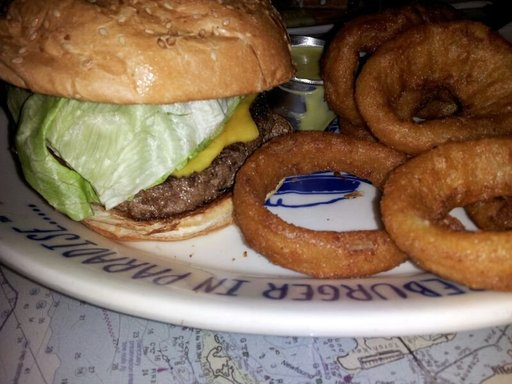

In [426]:
img = dataset["train"][10]["image"]
img

In [427]:
dataset["train"][10]["label"]

53

In [434]:
labels = dataset["train"].features["label"].names
labels[53]

'hamburger'

In [439]:
print(len(labels))

101


# Inference without training

In [440]:
from transformers import pipeline

classifier = pipeline("image-classification", model="google/vit-base-patch16-224")

In [406]:
classifier(img)

[{'score': 0.9848164916038513, 'label': 'cheeseburger'},
 {'score': 0.004266170784831047, 'label': 'plate'},
 {'score': 0.003371142316609621, 'label': 'bagel, beigel'},
 {'score': 0.0008194032707251608, 'label': 'meat loaf, meatloaf'},
 {'score': 0.0004135691560804844, 'label': 'bakery, bakeshop, bakehouse'}]

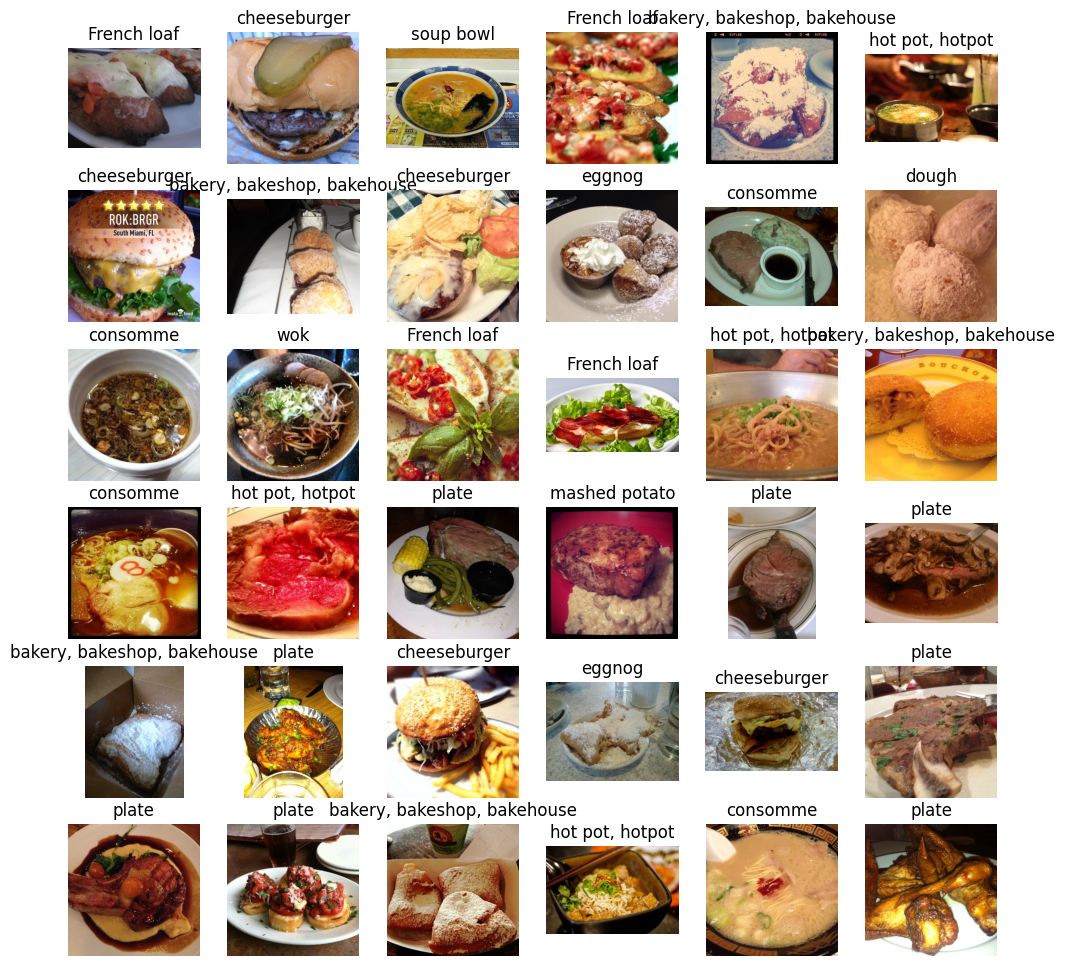

In [441]:
plt.figure(figsize=(12, 12))

for index, img in enumerate(dataset["test"][:36]["image"]):
    plt.subplot(6, 6, index + 1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(classifier(img)[0]['label'])

# Training

## Label mapping

In [445]:
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

print(id2label)

{'0': 'apple_pie', '1': 'baby_back_ribs', '2': 'baklava', '3': 'beef_carpaccio', '4': 'beef_tartare', '5': 'beet_salad', '6': 'beignets', '7': 'bibimbap', '8': 'bread_pudding', '9': 'breakfast_burrito', '10': 'bruschetta', '11': 'caesar_salad', '12': 'cannoli', '13': 'caprese_salad', '14': 'carrot_cake', '15': 'ceviche', '16': 'cheesecake', '17': 'cheese_plate', '18': 'chicken_curry', '19': 'chicken_quesadilla', '20': 'chicken_wings', '21': 'chocolate_cake', '22': 'chocolate_mousse', '23': 'churros', '24': 'clam_chowder', '25': 'club_sandwich', '26': 'crab_cakes', '27': 'creme_brulee', '28': 'croque_madame', '29': 'cup_cakes', '30': 'deviled_eggs', '31': 'donuts', '32': 'dumplings', '33': 'edamame', '34': 'eggs_benedict', '35': 'escargots', '36': 'falafel', '37': 'filet_mignon', '38': 'fish_and_chips', '39': 'foie_gras', '40': 'french_fries', '41': 'french_onion_soup', '42': 'french_toast', '43': 'fried_calamari', '44': 'fried_rice', '45': 'frozen_yogurt', '46': 'garlic_bread', '47': '

## Data preprocessing

In [448]:
# from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

# normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
# size = (
#     image_processor.size["shortest_edge"]
#     if "shortest_edge" in image_processor.size
#     else (image_processor.size["height"], image_processor.size["width"])
# )
# _transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

Mapping dataset is possible with https://huggingface.co/docs/datasets/v2.14.5/en/package_reference/main_classes#datasets.Dataset.with_transform 

In [490]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def encode(item):
    data = processor(item["image"], return_tensors='pt')
    data["label"] = item["label"]
    return data

encoded_dataset = dataset.with_transform(encode)

## Final Training

Instead of the original image classifier model, we download `-in21k` variant which is only the feature extractor for further training

In [446]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [485]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [ ]:
training_args = TrainingArguments(
    output_dir="out_super_classifier",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    # load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

trainer.train()

hamburger


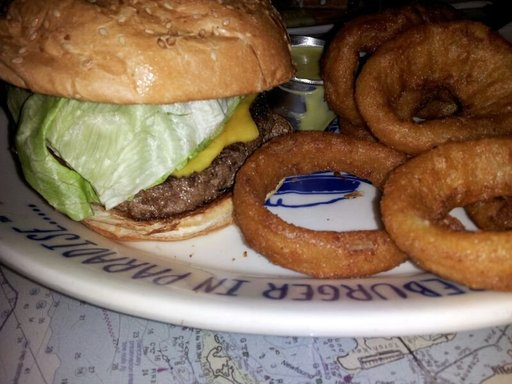

In [95]:
img = dataset["train"][10]["image"]
label = dataset["train"][10]["label"]

print(id2label[str(label)])
img

# Inference before training

## Single image

In [227]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

checkpoint = "google/vit-base-patch16-224"# -in21k"
processor = ViTImageProcessor.from_pretrained(checkpoint)

input = processor(images=img, return_tensors='pt')
input

{'pixel_values': tensor([[[[-0.9451, -0.9529, -0.9765,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9608, -0.9843, -0.9686,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9373, -0.9686, -0.9529,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.2549, -0.2235, -0.2235,  ...,  0.3255,  0.3098,  0.2941],
          [-0.2627, -0.2314, -0.2235,  ...,  0.3255,  0.3098,  0.3020],
          [-0.2549, -0.2392, -0.2235,  ...,  0.3176,  0.3176,  0.3176]],

         [[-0.9608, -0.9608, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9686, -0.9922, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9451, -0.9843, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.3490, -0.3255, -0.3255,  ...,  0.1843,  0.1686,  0.1451],
          [-0.3647, -0.3333, -0.3255,  ...,  0.1765,  0.1608,  0.1451],
          [-0.3569, -0.3412, -0.3255,  ...,  0.1686,  0.1529,  0.1451]],

         [[-0.9922, -0.9922, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0

In [383]:
from transformers import ViTForImageClassification
import torch

model = ViTForImageClassification.from_pretrained(checkpoint)

with torch.no_grad():
    outputs = model(**input)

outputs.logits.shape

torch.Size([1, 1000])

In [384]:
outputs.logits

tensor([[ 8.7543e-02,  2.8306e-01,  2.4851e-02,  6.4850e-03, -2.7881e-01,
          1.5007e+00,  2.0030e-01, -8.6866e-01, -4.0639e-01, -1.4361e+00,
          5.7952e-01, -7.1079e-01, -6.6867e-01,  7.1778e-01, -1.1045e+00,
         -8.9234e-01,  4.9867e-01,  3.4634e-01,  2.3620e-01, -8.3934e-01,
         -2.2418e-01,  9.2813e-01, -6.1045e-01, -8.7950e-01, -9.6973e-01,
         -2.9552e-01, -1.1451e-01, -5.6099e-01,  5.7869e-01,  1.0930e+00,
         -6.8969e-01, -6.5892e-01, -2.8056e-01, -7.9110e-01, -9.2353e-01,
         -8.4856e-01,  3.0977e-01, -8.2217e-02, -1.1589e+00, -2.6401e-01,
          2.1656e-01, -2.1709e-01, -8.5949e-01, -1.1547e+00, -3.2571e-01,
          6.0968e-01,  2.9351e-01, -2.8098e-01,  1.6788e-01, -1.2452e+00,
         -1.1179e+00, -3.9247e-01, -1.0686e+00, -1.1211e+00, -7.8729e-01,
         -8.6943e-02, -6.1685e-01, -8.6714e-01, -8.6820e-01,  8.5068e-02,
         -1.3821e-01, -3.7853e-01,  3.3621e-01, -7.3625e-01, -1.8639e-01,
         -2.9548e-01, -4.4592e-01, -6.

In [385]:
label_id = outputs.logits.argmax(1)
label_id

tensor([933])

In [386]:
model.config.id2label[label_id.item()]

'cheeseburger'

## Few more images

In [374]:
test_data = processor(dataset["test"][:36]["image"], return_tensors="pt")

In [389]:
with torch.no_grad():
    logits = model(**test_data).logits.argmax(1)

logits

tensor([930, 933, 809, 930, 415, 926, 933, 415, 933, 969, 925, 961, 925, 909,
        930, 930, 926, 415, 925, 926, 923, 935, 923, 923, 415, 923, 933, 969,
        933, 923, 923, 923, 415, 926, 925, 923])

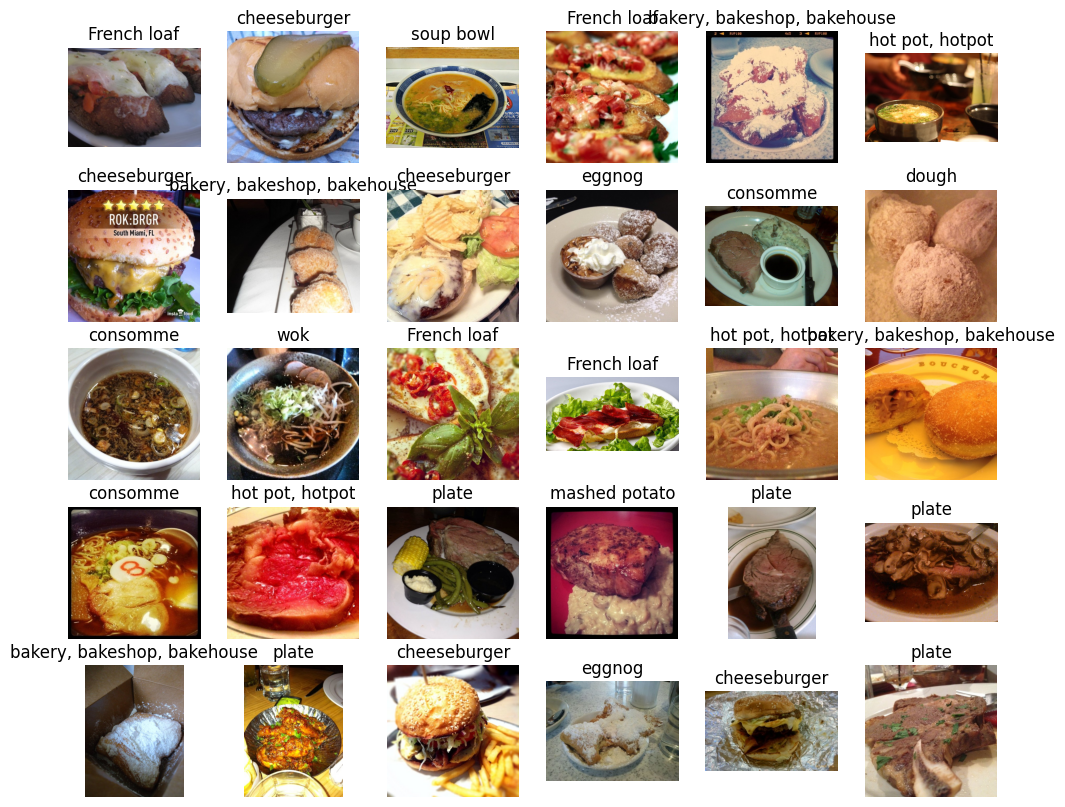

In [390]:
plt.figure(figsize=(12, 12))

for index, (logit, img) in enumerate(zip(logits, dataset["test"][:30]["image"])):
    plt.subplot(6, 6, index + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(model.config.id2label[logit.item()])

# Training

In [392]:
len(labels)

101

In [368]:
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from transformers import pipeline


model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

classifier = pipeline("image-classification", model=checkpoint)
classifier(dataset["train"][10]["image"])

RuntimeError: Error(s) in loading state_dict for ViTForImageClassification:
	size mismatch for classifier.weight: copying a param with shape torch.Size([1000, 768]) from checkpoint, the shape in current model is torch.Size([101, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([101]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

In [169]:
import evaluate

accuracy = evaluate.load("accuracy")

import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)